# Transactions Fraud Detection

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Timotej Zatko](https://github.com/timzatko)

## Prototype #1 Grey Wolf Algorithm Application on Decision Tree Classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.append('..')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

from NiaPy.task import StoppingTask, OptimizationType
from NiaPy.algorithms.basic import GreyWolfOptimizer

from src.algorithms.gray_wolf_optimizer_multiprocessing import GreyWolfOptimizerMultiprocessing

from src.dataset import load_processed_data
from src.evaluation import custom_classification_report

from src.classification_benchmark import ClassificationBenchmark

### Load the data

In [3]:
%%time

x_train, y_train, _, _ = load_processed_data(frac=0.01)

Number of records:
  x_train - 4724
  y_train - 4724
  x_test - 1181
  y_test - 1181
CPU times: user 57.7 s, sys: 6.22 s, total: 1min 3s
Wall time: 1min 20s


### Setup classification benchmark

In [4]:
def model_fn():
    return DecisionTreeClassifier(random_state=42)

In [5]:
columns_count = len(x_train.columns)

_x_train, _x_val, _y_train, _y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

benchmark = ClassificationBenchmark(
    model_fn,
    roc_auc_score,
    _x_train,
    _y_train,
    _x_val,
    _y_val
)

### Find optimal features

In [9]:
def optimize(benchmark, nGEN):
    """
    Optimize task with GWO optimizer.
    
    :param benchmark: NiaPy.Benchmark to optimize
    :param nGEN: number of generations
    """
    
    best_columns = None
    best_score = 0
    
    for i in range(5):
        # when using OptimizationType.MAXIMIZATION, the library will fail
        # we use OptimizationType.MINIMIZATION instead and invert the score
        task = StoppingTask(D=benchmark.get_length(), nGEN=nGEN, optType=OptimizationType.MINIMIZATION, benchmark=benchmark)
        algo = GreyWolfOptimizer(NP=25)
        # algo = GreyWolfOptimizerMultiprocessing(NP=25)
        solution_vec, score = algo.run(task=task)    
        
        # invert the score
        score = 1 - score
        columns = benchmark.select_columns(solution_vec)
        
        print(f'Score: {score}')
        print(columns)
        print('\n')
        
        if score > best_score:
            best_score = score
            best_columns = columns

    print('---')
    print(f'Score: {best_score}')
            
    return best_columns


Find the optimal combination of columns.

In [10]:
%%time

columns = optimize(benchmark, 10)

Score: 0.7627055833980377
['TransactionDT', 'C1', 'C3', 'C5', 'C6', 'C7', 'C10', 'C12', 'D2', 'D4', 'D11', 'D15', 'V1', 'V2', 'V5', 'V7', 'V8', 'V10', 'V11', 'V16', 'V18', 'V19', 'V21', 'V22', 'V23', 'V24', 'V26', 'V27', 'V31', 'V32', 'V35', 'V36', 'V37', 'V39', 'V42', 'V43', 'V45', 'V47', 'V48', 'V50', 'V54', 'V56', 'V59', 'V63', 'V66', 'V68', 'V69', 'V71', 'V72', 'V73', 'V75', 'V76', 'V81', 'V83', 'V85', 'V88', 'V92', 'V93', 'V95', 'V96', 'V98', 'V101', 'V102', 'V103', 'V104', 'V106', 'V111', 'V112', 'V113', 'V115', 'V119', 'V120', 'V126', 'V131', 'V132', 'V280', 'V281', 'V283', 'V284', 'V288', 'V292', 'V294', 'V297', 'V300', 'V302', 'V303', 'V305', 'V306', 'V317', 'V318', 'ProductCD_H', 'ProductCD_R', 'ProductCD_other', 'card2_490.0', 'card2_555.0', 'card6_credit', 'card6_debit', 'addr2_other', 'M1_T', 'M2_T', 'M2_other', 'M3_T', 'M3_other', 'M6_other']


Score: 0.7627055833980377
['C1', 'C4', 'C5', 'C6', 'C7', 'C8', 'C11', 'C12', 'C14', 'D4', 'V1', 'V2', 'V4', 'V9', 'V12', 'V13', '

We found the best solution from 5 independent runs of GWO algorithm. During every run we captured a different solution. For the final submission, we probably would not like to use "the best one", because we would like to have some variance. Maybe we can try to merge these solution together.

### Train only with selected features and evaluate on test data

We will train the model with selected features on the whole dataset.

In [11]:
x_train, y_train, x_test, y_test = load_processed_data()

Number of records:
  x_train - 472432
  y_train - 472432
  x_test - 118108
  y_test - 118108


Train classifier with selected features.

In [12]:
%%time

clf = model_fn()
clf = clf.fit(x_train[columns], y_train)

CPU times: user 36 s, sys: 1.3 s, total: 37.3 s
Wall time: 37.4 s


Evaluate trained model.

not fraud
precision: 0.9804243584564313
recall: 0.981985310287197
f1-score: 0.981204213560916
support: 113685


is fraud
precision: 0.5172088637435172
recall: 0.49604340945059916
f1-score: 0.5064050778995961
support: 4423


accuracy: 0.9637873810410811


macro avg
precision: 0.7488166110999742
recall: 0.7390143598688981
f1-score: 0.7438046457302561
support: 118108


weighted avg
precision: 0.9630775052956358
recall: 0.9637873810410811
f1-score: 0.9634235672284913
support: 118108


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
micro: 0.7488166110999742
macro: 0.7488166110999742
samples: 0.7488166110999742
weighted: 0.7488166110999742


CPU times: user 1.02 s, sys: 16.3 ms, total: 1.03 s
Wall time: 1.02 s


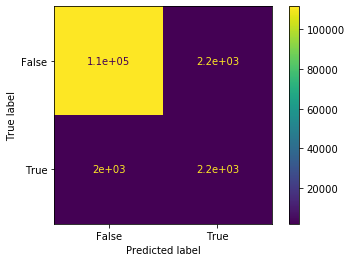

In [13]:
%%time

custom_classification_report(clf, x_test[columns], y_test)